In [1]:
import os
import numpy as np
import pandas as pd
import collections 
# import dask.dataframe as dd
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sentence_transformers import SentenceTransformer
from multiprocessing import Pool, cpu_count
import torch
import time
print(torch.cuda.is_available()) 

C:\Users\Sidhant Saxena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange



True


### Stratified Data Sampling and analysis

In [2]:
def facet_grid(df,param,usefulness):
    # print(f"{param} across different stars")
    graph = sns.FacetGrid(data=df,col='stars')
    graph.map(plt.hist,param,bins=5,color='green')
    graph.fig.suptitle(f"Distribution of {param} Across Different Star Ratings(useful threshold {usefulness})", y=1.05)
    plt.show()
    

def create_df_analyse(path,sample_size_per_class,usefulness_threshold):
    count_1star, count_2star, count_3star, count_4star, count_5star = sample_size_per_class, sample_size_per_class, sample_size_per_class, sample_size_per_class, sample_size_per_class
    data = []
    with open(path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            review = json.loads(line)
            if review['stars'] == 1 and count_1star > 0 and review['useful'] > usefulness_threshold:
                data.append(review)
                count_1star -= 1
            elif review['stars'] == 2 and count_2star > 0 and review['useful'] > usefulness_threshold:
                data.append(review)
                count_2star -= 1
            elif review['stars'] == 3 and count_3star > 0 and review['useful'] > usefulness_threshold:
                data.append(review)
                count_3star -= 1
            elif review['stars'] == 4 and count_4star > 0 and review['useful'] > usefulness_threshold:
                data.append(review)
                count_4star -= 1
            elif review['stars'] == 5 and count_5star > 0 and review['useful'] > usefulness_threshold:
                data.append(review)
                count_5star -= 1
            if (count_1star ==0) and (count_2star ==0) and (count_3star ==0) and (count_4star ==0) and (count_5star ==0):
                break
    df = pd.DataFrame(data)[['text', 'stars', 'useful']]
    df['length'] = df['text'].apply(len)
    facet_grid(df,'length',usefulness_threshold+1)
    facet_grid(df,'useful',usefulness_threshold+1)
    return df
    
    

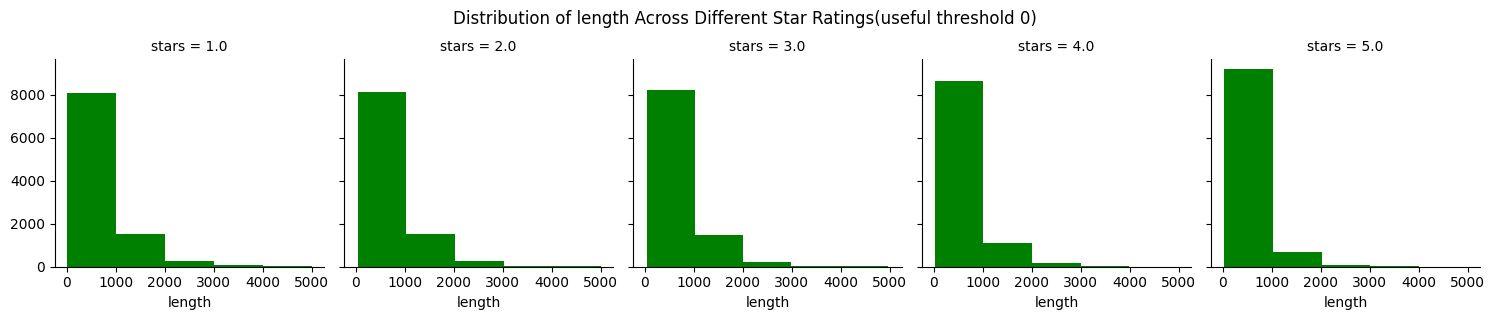

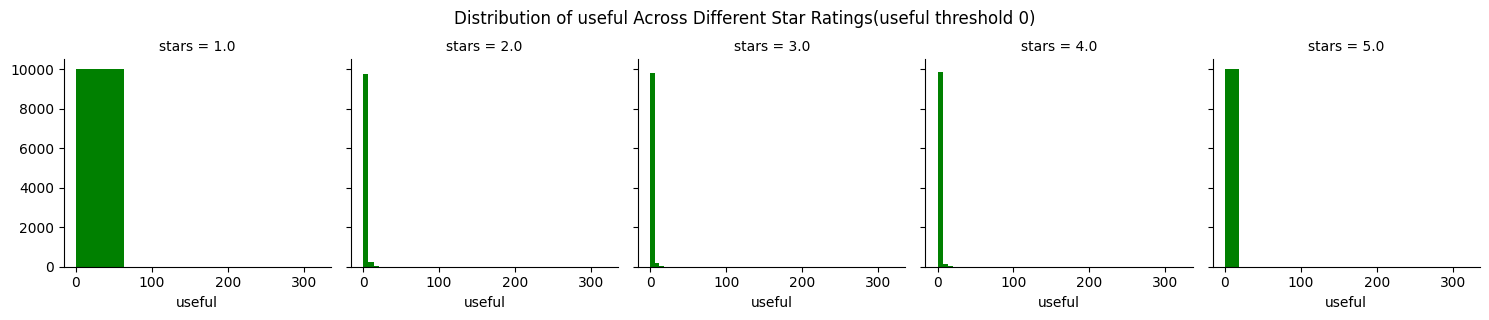

,stars,useful,length
count,50000.000000,50000.000000,50000.000000
mean,3.000000,1.006580,604.545160
std,1.414228,2.610309,543.643524
min,1.000000,0.000000,3.000000
25%,2.000000,0.000000,249.000000
50%,3.000000,0.000000,439.000000
75%,4.000000,1.000000,771.000000
max,5.000000,320.000000,5000.000000


In [3]:
df = create_df_analyse('yelp_academic_dataset_review.json',10000,-1)
df.describe()

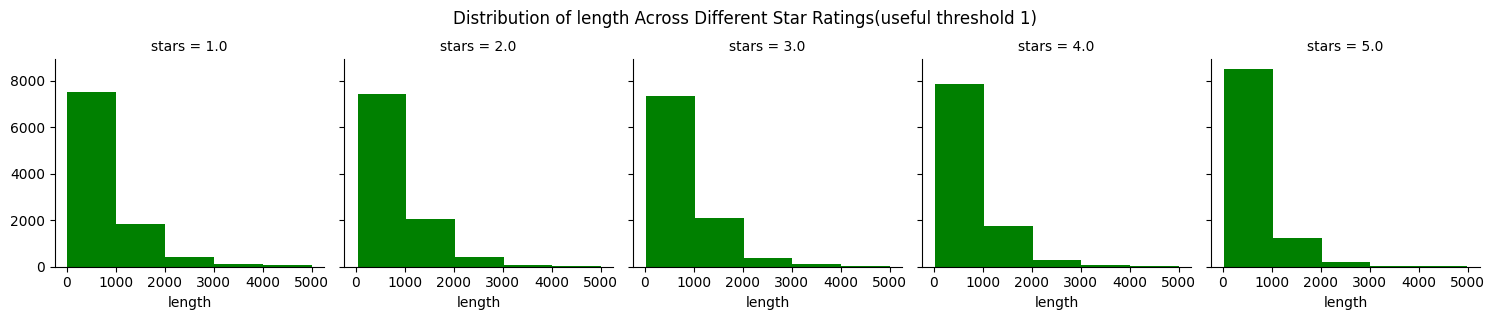

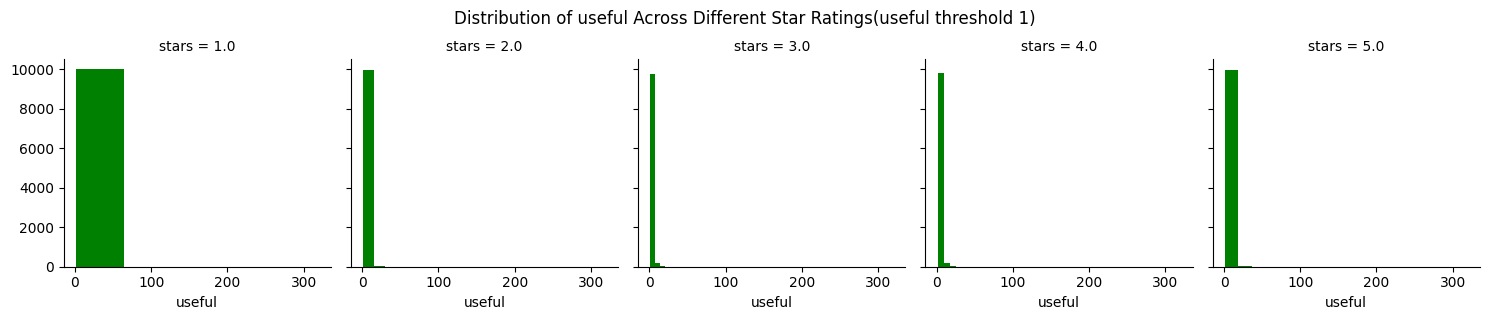

,stars,useful,length
count,50000.000000,50000.000000,50000.000000
mean,3.000000,2.304740,748.413580
std,1.414228,2.994571,634.039594
min,1.000000,1.000000,3.000000
25%,2.000000,1.000000,324.000000
50%,3.000000,1.000000,566.000000
75%,4.000000,3.000000,964.000000
max,5.000000,320.000000,5000.000000


In [4]:
df = create_df_analyse('yelp_academic_dataset_review.json',10000,0)
df.describe()

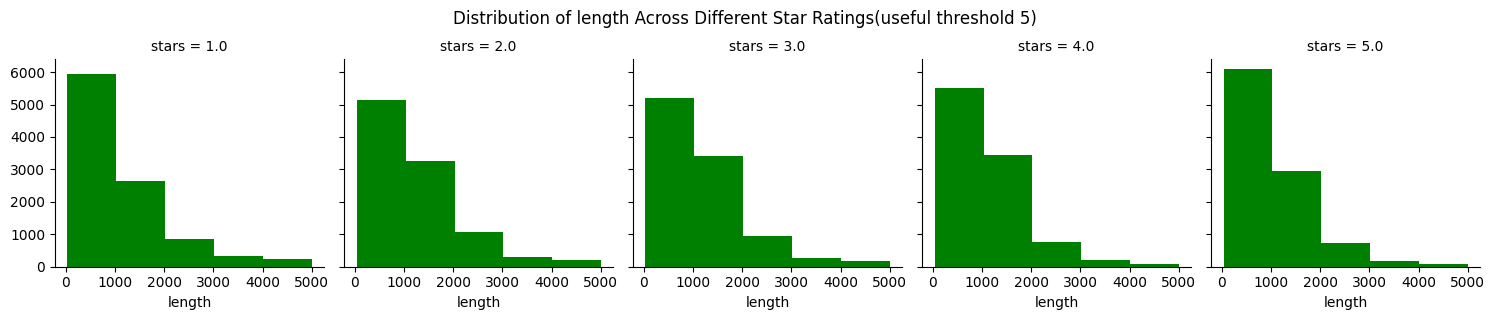

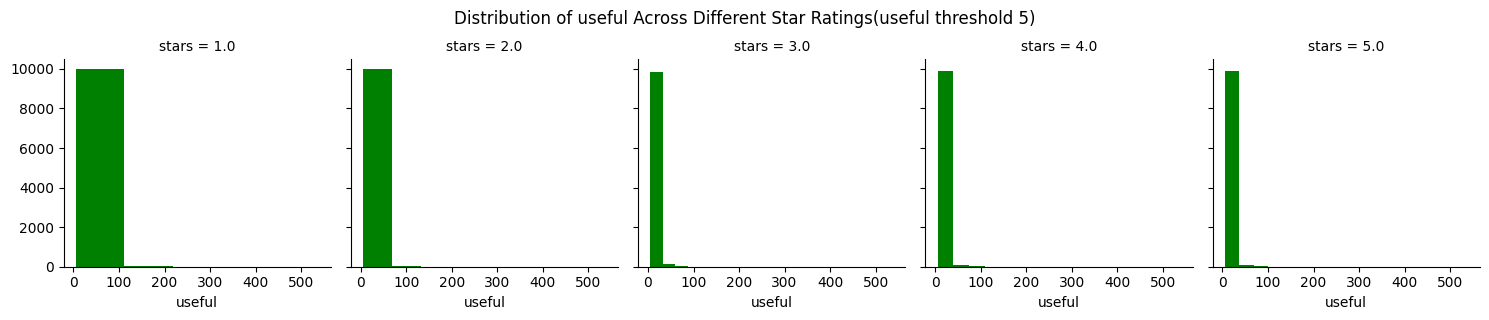

,stars,useful,length
count,50000.000000,50000.00000,50000.000000
mean,3.000000,8.79346,1151.198880
std,1.414228,8.64944,848.737025
min,1.000000,5.00000,23.000000
25%,2.000000,5.00000,562.000000
50%,3.000000,7.00000,926.000000
75%,4.000000,9.00000,1485.000000
max,5.000000,539.00000,5000.000000


In [5]:
df = create_df_analyse('yelp_academic_dataset_review.json',10000,4)
df.describe()

In [6]:
df['stars'].value_counts()

stars
5.0    10000
4.0    10000
2.0    10000
1.0    10000
3.0    10000
Name: count, dtype: int64

In [7]:
df.head()

,text,stars,useful,length
0,I LOVE Weaver's Way and really disagree with s...,5.0,7,1494
1,This is the first time I tried this place and ...,4.0,7,465
2,"I took the beginning class there, and I loved ...",5.0,15,317
3,Came in after attending the Zurich Classic gol...,4.0,5,485
4,I've been wanting to try Trust Me BBQ for over...,2.0,5,980


In [12]:
# nltk.download('stopwords')
# nltk.download('wordnet')

### Text Cleanup Function

In [8]:
def clean_text(text,keep_stop_words):
    lemmatizer = WordNetLemmatizer()
    if keep_stop_words:
        stop_words = ()
    else:
        stop_words = ('a', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', 'came', 'can',  'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes',  'consequently', 'consider', 'considering', 'corresponding', 'could', 'course', 'currently', 'd', 'definitely', 'described', 'despite', 'did', 'different', 'do', 'does', 'doing', 'done', 'down', 'downwards', 'during', 'e', 'each', 'edu', 'eg', 'eight', 'either', 'else', 'elsewhere', 'enough', 'entirely', 'especially', 'et', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'f', 'fifth', 'first', 'five', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 'forth', 'four', 'from', 'further', 'furthermore', 'g', 'get', 'gets', 'getting', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'h', 'had', 'happens', 'hardly', 'has', 'have', 'having', 'he', 'hello', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'hi', 'him', 'himself', 'his', 'hither', 'hopefully', 'how', 'howbeit', 'however', 'i', 'ie', 'if',  'immediate', 'in', 'inasmuch', 'inc', 'indeed', 'indicate', 'indicated', 'indicates', 'inner', 'insofar', 'instead', 'into', 'inward', 'is', 'it', 'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'know', 'knows', 'known', 'l', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'like', 'liked', 'likely', 'little', 'look', 'looking', 'looks', 'ltd', 'm', 'mainly', 'many', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'merely', 'might', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'my', 'myself', 'n', 'name', 'namely', 'nd', 'near', 'nearly', 'need', 'needs', 'neither','nevertheless', 'new', 'next', 'nine',  'nobody', 'non', 'none', 'noone', 'nor', 'normally',  'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'p', 'particular', 'particularly', 'per', 'perhaps', 'placed', 'please', 'plus', 'possible', 'presumably', 'probably', 'provides', 'q', 'que', 'quite', 'qv', 'r', 'rather', 'rd', 're', 'really', 'regarding', 'regardless', 'regards', 'relatively', 'respectively', 'right', 's', 'said', 'same', 'saw', 'say', 'saying', 'says', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'seven', 'several', 'shall', 'she', 'should', 'since', 'six', 'so', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry', 'specified', 'specify', 'specifying', 'still', 'sub', 'such', 'sup', 'sure', 't', 'take', 'taken', 'tell', 'tends', 'th', 'than', 'thanx', 'that', 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', 'thereupon', 'these', 'they', 'think', 'third', 'this', 'thorough', 'thoroughly', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'twice', 'two', 'u', 'un', 'under',  'unless', 'until', 'unto', 'up', 'upon', 'us', 'use', 'uses', 'using', 'usually', 'uucp', 'v', 'value', 'various', 'very', 'via', 'viz', 'vs', 'w', 'want', 'wants', 'was', 'way', 'we', 'welcome', 'well', 'went', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'willing', 'wish', 'with', 'within', 'without', 'wonder', 'would', 'would', 'x', 'y', 'yes', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'z', 'zero')
    text = text.lower()
    text = re.sub(r"[\[\]\(\)\{\}.,\?]", "", text)  # Remove punctuation
    text = text.strip()
    words = text.split()  

    imp_word = []
    for word in words:
        if word.isalpha() and word not in stop_words:  # Check if word is alphabetical 
            lemm_word = lemmatizer.lemmatize(word)
            for type_w in ['n', 'v', 'a', 'r']:  # Explicitly lemmatizing noun, verbs, adjectives, adverbs
                lemm_word = lemmatizer.lemmatize(lemm_word, pos=type_w)
            imp_word.append(lemm_word)

    text_imp = ' '.join(imp_word)
    return text_imp


### TF-IDF Analysis

In [9]:
df['tfidf_text'] = df['text'].apply(lambda x: clean_text(x, keep_stop_words=False)) 
df.head()

,text,stars,useful,length,tfidf_text
0,I LOVE Weaver's Way and really disagree with s...,5.0,7,1494,love disagree content previous review ww not n...
1,This is the first time I tried this place and ...,4.0,7,465,time place surprisingly surprise combination d...
2,"I took the beginning class there, and I loved ...",5.0,15,317,begin class love perfectly pace move difficult...
3,Came in after attending the Zurich Classic gol...,4.0,5,485,attend zurich classic golf tournament warm bit...
4,I've been wanting to try Trust Me BBQ for over...,2.0,5,980,want trust bbq year stop month ago wait line m...


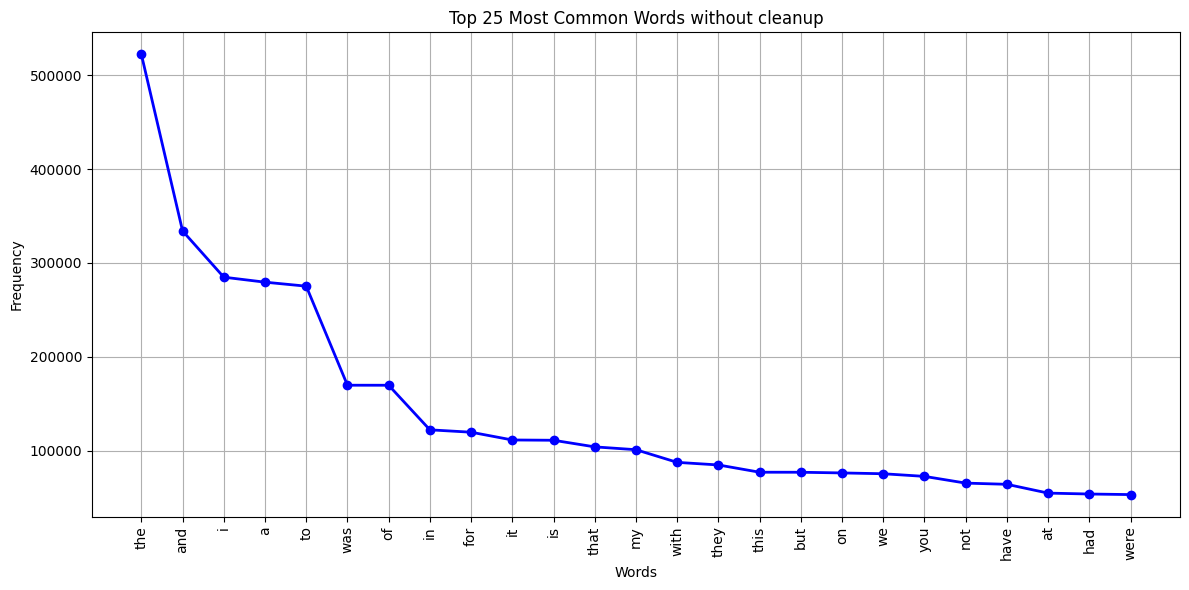

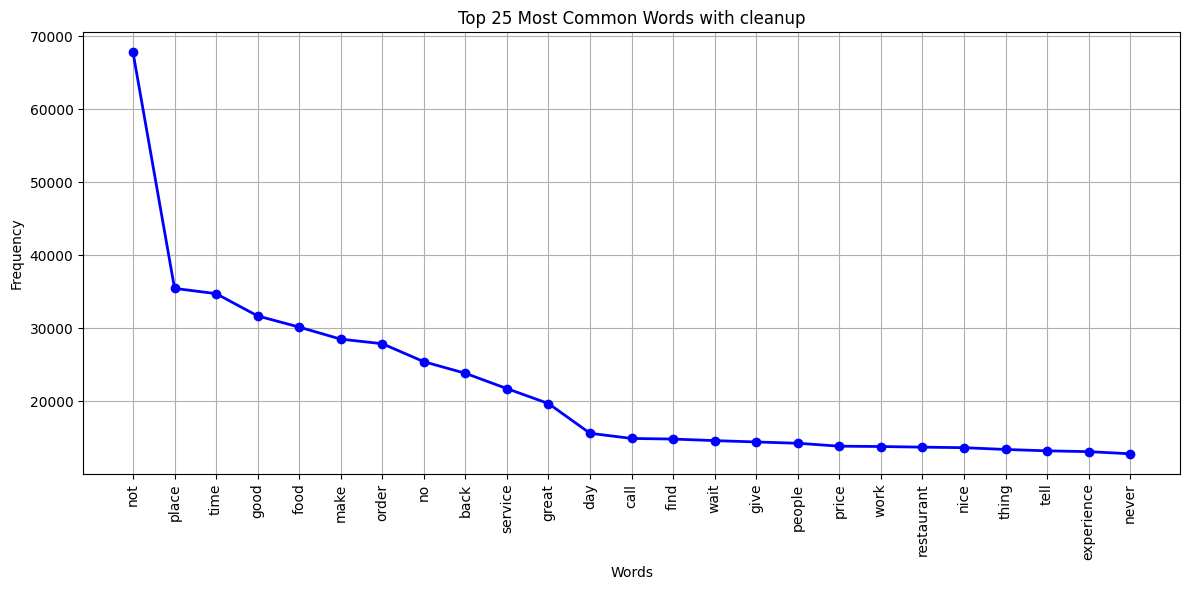

In [10]:
def most_freq_words(df,col_name,title):
    all_words = []
    for line in list(df[col_name]):
        for word in line.split():
            all_words.append(word.lower())
    text_mfreq = collections.Counter(all_words).most_common(25)
    words, frequencies = zip(*text_mfreq)
    plt.figure(figsize=(12, 6))
    plt.plot(words, frequencies, marker='o', color='b', linestyle='-', linewidth=2)
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(visible=True)
    plt.tight_layout()
    plt.show()

most_freq_words(df,'text','Top 25 Most Common Words without cleanup')
most_freq_words(df,'tfidf_text','Top 25 Most Common Words with cleanup')

In [11]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(df['tfidf_text'].fillna(''))


bigram_counts = X.sum(axis=0).A1
bigram_names = vectorizer.get_feature_names_out()

bigram_count_output = [(tuple(bigram.split()), count) for bigram, count in zip(bigram_names, bigram_counts)]
bigram_count_output_sorted = sorted(bigram_count_output, key=lambda x: x[1], reverse=True)

# Display top bigrams (e.g., top 3)
print(bigram_count_output_sorted[:30])

[(('customer', 'service'), 3556), (('ice', 'cream'), 1785), (('pretty', 'good'), 1626), (('not', 'good'), 1498), (('park', 'lot'), 1428), (('happy', 'hour'), 1375), (('give', 'star'), 1308), (('food', 'good'), 1294), (('highly', 'recommend'), 1257), (('call', 'back'), 1245), (('front', 'desk'), 1241), (('year', 'ago'), 1161), (('not', 'bad'), 1112), (('make', 'feel'), 1078), (('staff', 'friendly'), 1064), (('wait', 'minute'), 1063), (('good', 'not'), 998), (('not', 'worth'), 968), (('great', 'place'), 935), (('long', 'time'), 930), (('credit', 'card'), 897), (('year', 'old'), 868), (('good', 'thing'), 857), (('din', 'room'), 839), (('come', 'back'), 831), (('not', 'great'), 829), (('mac', 'cheese'), 816), (('food', 'not'), 814), (('fry', 'chicken'), 813), (('place', 'not'), 813)]


In [12]:
bigram_df = pd.DataFrame(bigram_count_output_sorted[:30], columns=['bigram', 'count'])
bigram_df

,bigram,count
0,"(customer, service)",3556
1,"(ice, cream)",1785
2,"(pretty, good)",1626
3,"(not, good)",1498
4,"(park, lot)",1428
5,"(happy, hour)",1375
6,"(give, star)",1308
7,"(food, good)",1294
8,"(highly, recommend)",1257
9,"(call, back)",1245


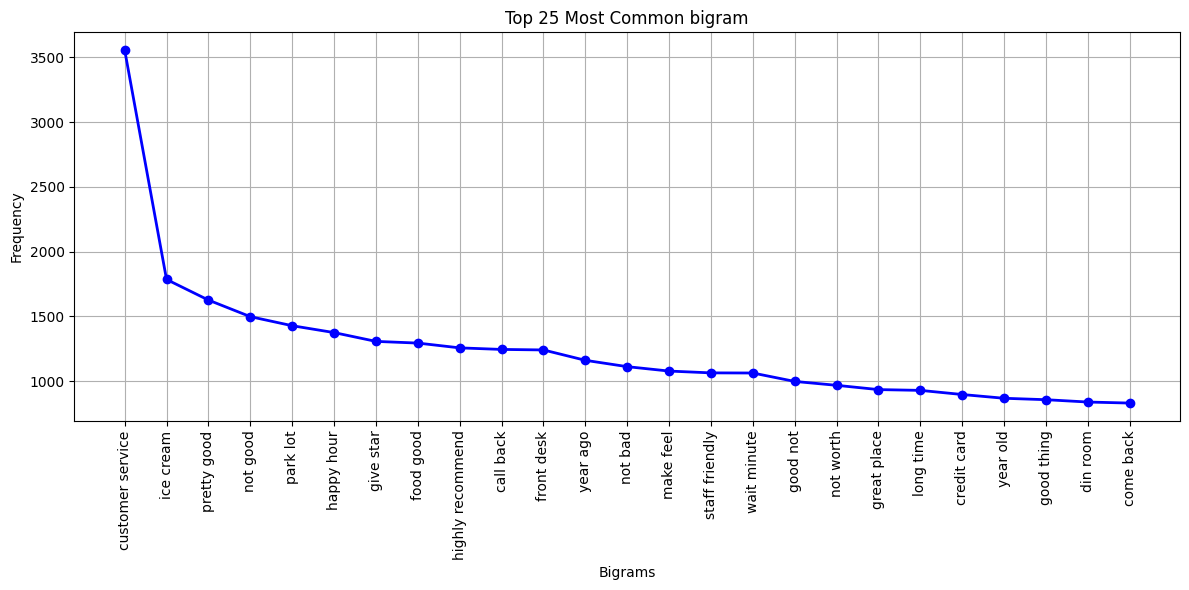

In [13]:
import collections
import matplotlib.pyplot as plt
from nltk import bigrams
from nltk.corpus import stopwords

def most_freq_bigrams(df, col_name, title):
    all_bigrams = []
    for line in list(df[col_name]):
        words = line.lower().split()  # Convert to lowercase and split words
        bigram_list = list(bigrams(words))  # Generate bigrams
        all_bigrams.extend(bigram_list)  # Add bigrams to the list

    # Count the frequency of each bigram
    bigram_freq = collections.Counter(all_bigrams).most_common(25)
    bigrams_text, frequencies = zip(*bigram_freq)

    # Convert bigram tuples to strings for plotting
    bigrams_text = [f"{w1} {w2}" for w1, w2 in bigrams_text]

    # Plot the most frequent bigrams
    plt.figure(figsize=(12, 6))
    plt.plot(bigrams_text, frequencies, marker='o', color='b', linestyle='-', linewidth=2)
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel('Bigrams')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(visible=True)
    plt.tight_layout()
    plt.show()

most_freq_bigrams(df,'tfidf_text','Top 25 Most Common bigram')

In [14]:
#Import the required packages

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

print(f"networkx version: {nx.__version__}")

networkx version: 3.4.1


In [15]:
# Graph building function

def build_graph(nodes, edges):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges) 
    plt.figure(figsize=(30,20))
    np.random.seed(12)
    plt.subplot()
    node_sizes = [1000 for _ in nodes] 
    pos = nx.spring_layout(G, k=0.25, seed=12) 
    nx.draw(G,pos, with_labels=True, font_weight='bold', node_color='violet', node_size=node_sizes)
    return G

Nodes: ['ago', 'back', 'bad', 'call', 'card', 'cheese', 'chicken', 'come', 'cream', 'credit', 'customer', 'desk', 'din', 'feel', 'food', 'friendly', 'front', 'fry', 'give', 'good', 'great', 'happy', 'highly', 'hour', 'ice', 'long', 'lot', 'mac', 'make', 'minute', 'not', 'old', 'park', 'place', 'pretty', 'recommend', 'room', 'service', 'staff', 'star', 'thing', 'time', 'wait', 'worth', 'year']
Edges: [('customer', 'service'), ('ice', 'cream'), ('pretty', 'good'), ('not', 'good'), ('park', 'lot'), ('happy', 'hour'), ('give', 'star'), ('food', 'good'), ('highly', 'recommend'), ('call', 'back'), ('front', 'desk'), ('year', 'ago'), ('not', 'bad'), ('make', 'feel'), ('staff', 'friendly'), ('wait', 'minute'), ('good', 'not'), ('not', 'worth'), ('great', 'place'), ('long', 'time'), ('credit', 'card'), ('year', 'old'), ('good', 'thing'), ('din', 'room'), ('come', 'back'), ('not', 'great'), ('mac', 'cheese'), ('food', 'not'), ('fry', 'chicken'), ('place', 'not')]


networkx.classes.graph.Graph

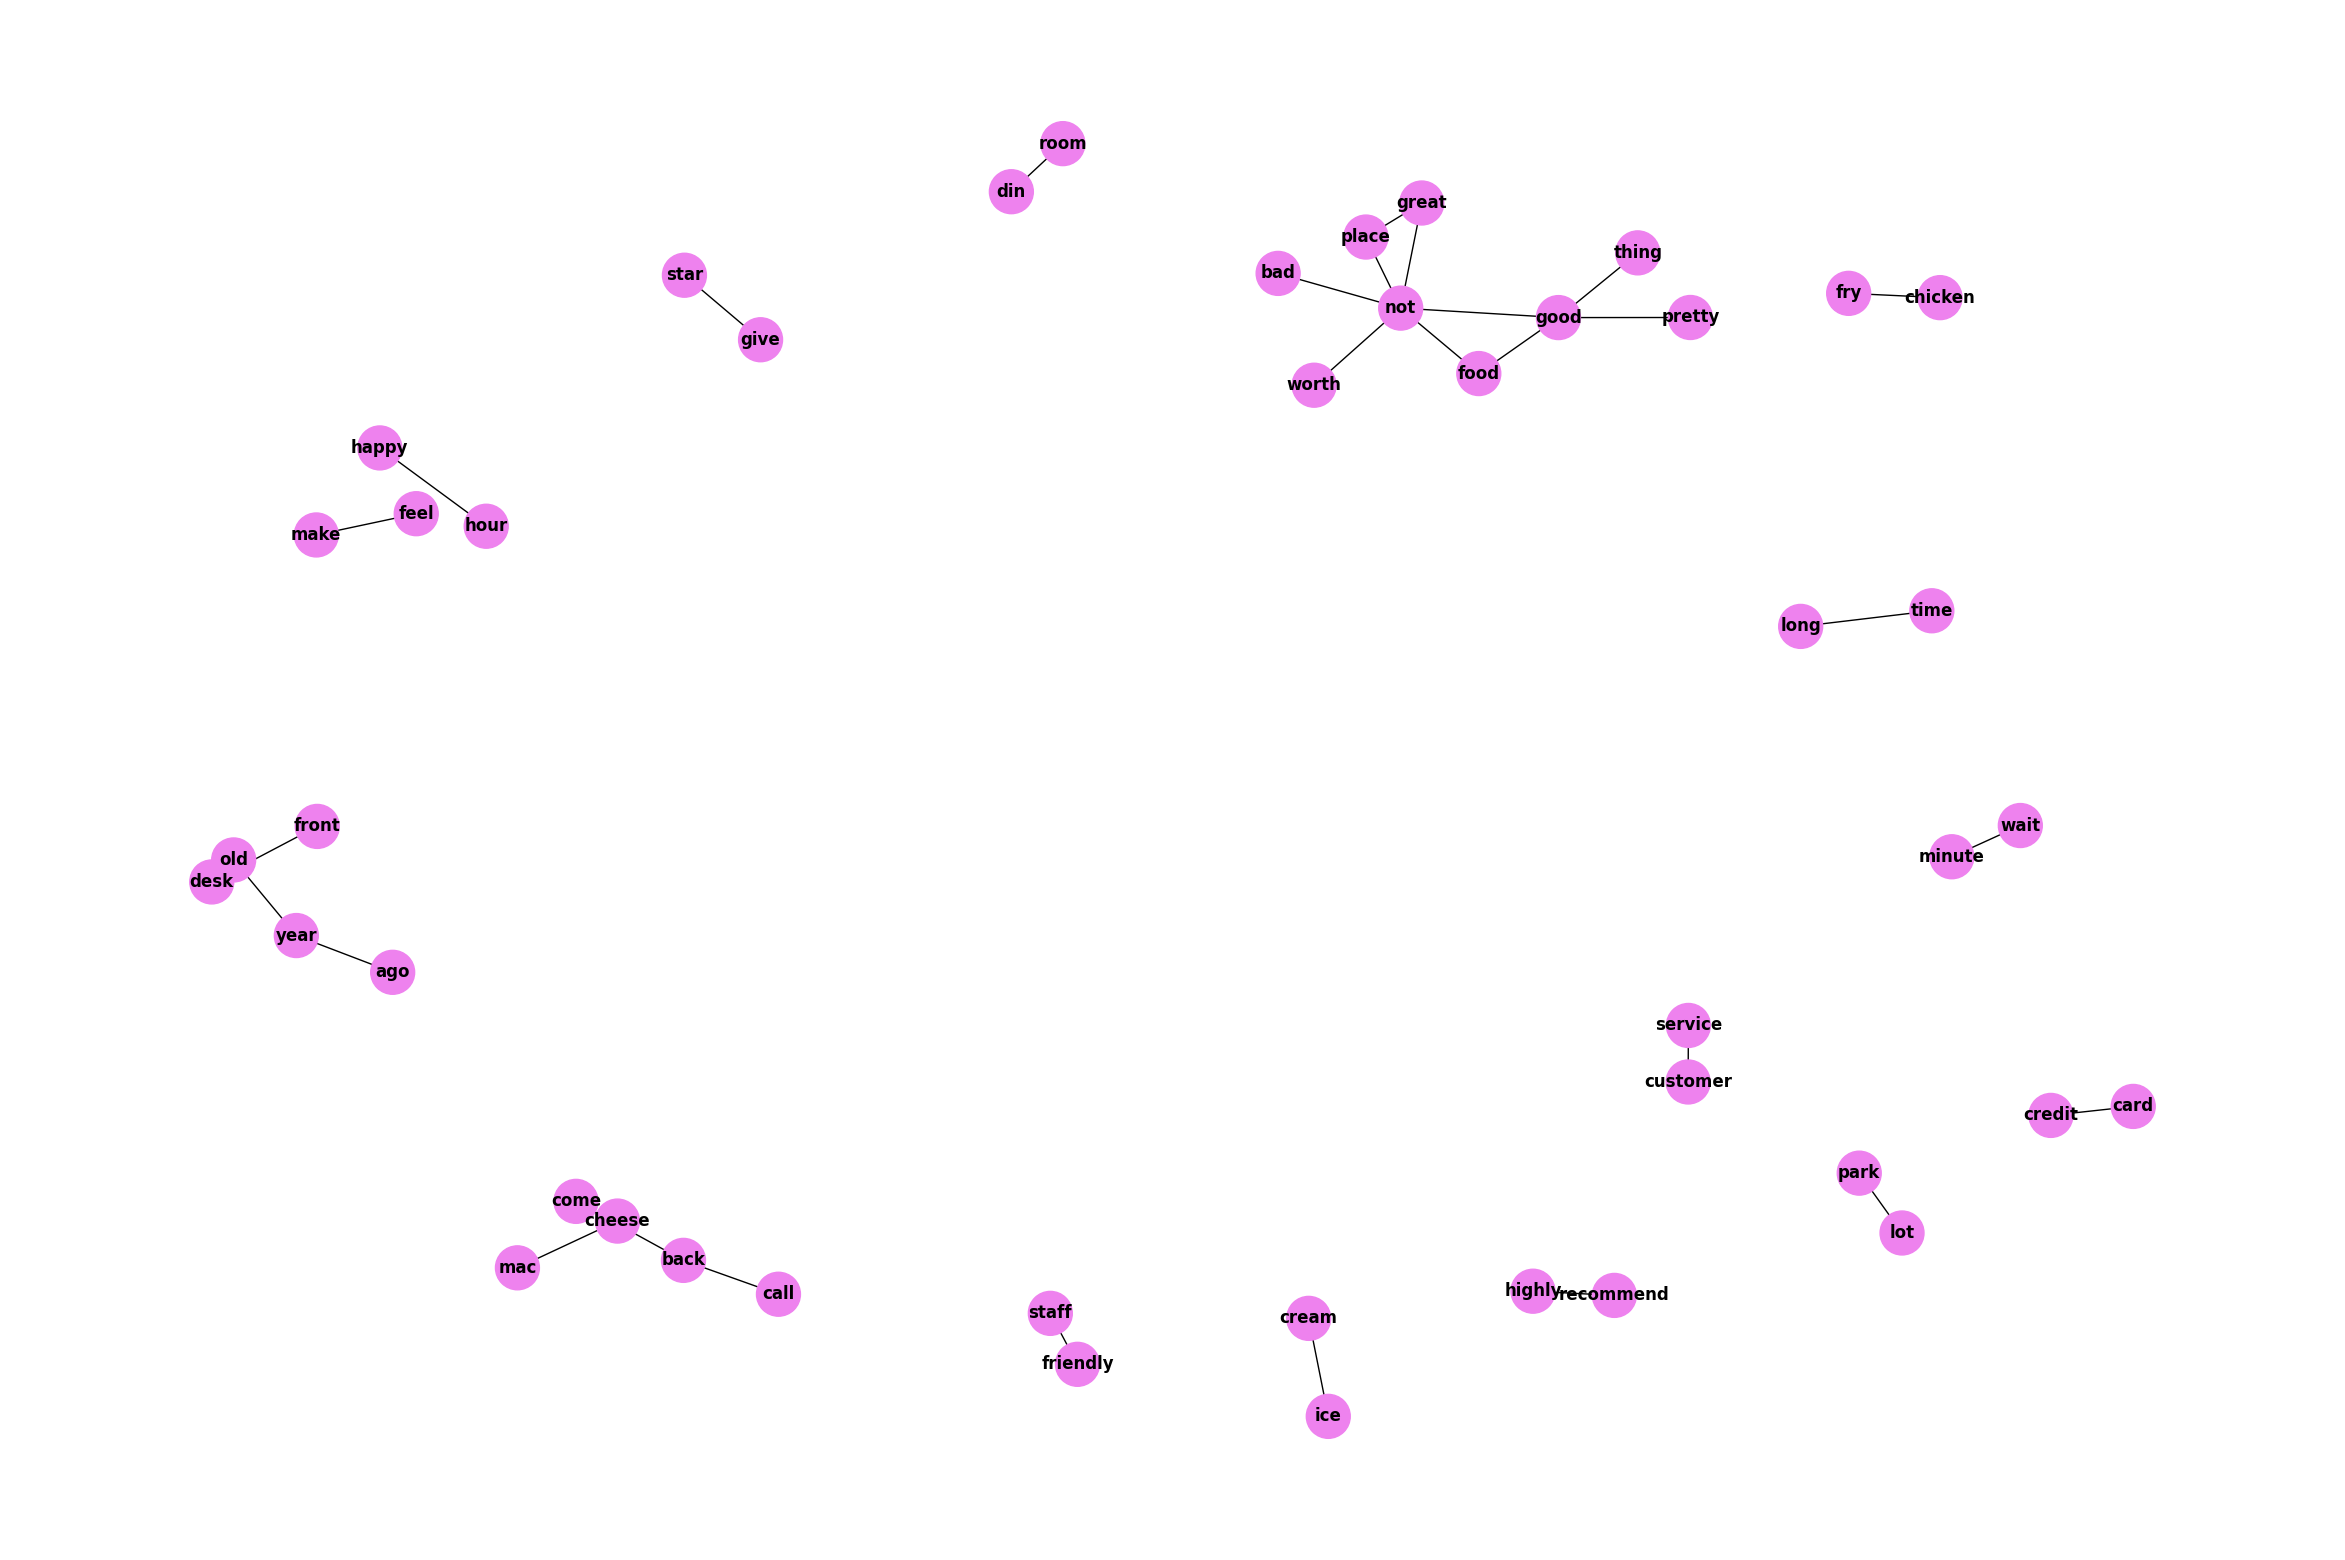

In [16]:
x=[(('customer', 'service'), 3556), (('ice', 'cream'), 1785), (('pretty', 'good'), 1626), (('not', 'good'), 1498), (('park', 'lot'), 1428), (('happy', 'hour'), 1375), (('give', 'star'), 1308), (('food', 'good'), 1294), (('highly', 'recommend'), 1257), (('call', 'back'), 1245), (('front', 'desk'), 1241), (('year', 'ago'), 1161), (('not', 'bad'), 1112), (('make', 'feel'), 1078), (('staff', 'friendly'), 1064), (('wait', 'minute'), 1063), (('good', 'not'), 998), (('not', 'worth'), 968), (('great', 'place'), 935), (('long', 'time'), 930), (('credit', 'card'), 897), (('year', 'old'), 868), (('good', 'thing'), 857), (('din', 'room'), 839), (('come', 'back'), 831), (('not', 'great'), 829), (('mac', 'cheese'), 816), (('food', 'not'), 814), (('fry', 'chicken'), 813),
   (('place', 'not'), 813)] # taken from bigram_df
nodes = set()  # Using a set to store unique words
for bigram, count in x:
    nodes.update(bigram)

# Convert nodes set to a sorted list
nodes = sorted(nodes)

# Create edges (bigrams)
edges = [(bigram[0], bigram[1]) for bigram, count in x]

# Display results
print("Nodes:", nodes)
print("Edges:", edges)
G = build_graph(nodes, edges)
type(G)

In [17]:
def tfidf_embedding(df, ngram_range, max_features,col_nm):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X = vectorizer.fit_transform(df['tfidf_text'])
    return X

In [ ]:
X = tfidf_embedding(df,(2, 2),1500,'tfidf_ub')

In [39]:
df_tfub = df[['text','stars']]
df_tfub['tfidf_ub'] = list(X_red)
df_tfub.head()

C:\Users\ashis\AppData\Local\Temp\ipykernel_2848\3624126064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tfub['tfidf_ub'] = list(X_red)


,text,stars,tfidf_ub
0,I LOVE Weaver's Way and really disagree with s...,5.0,"[0.0313308553774924, -0.06785093075057934, -0...."
1,This is the first time I tried this place and ...,4.0,"[0.023552010074871652, -0.04583937997683012, -..."
2,"I took the beginning class there, and I loved ...",5.0,"[0.007419014159715326, -0.013682239539640513, ..."
3,Came in after attending the Zurich Classic gol...,4.0,"[0.058795012561424005, -0.31804272060910577, 0..."
4,I've been wanting to try Trust Me BBQ for over...,2.0,"[0.04382798548025668, -0.07936146370246656, -0..."


In [40]:
start_time = time.time()
df_tfub.to_parquet('df_tfidf_bi_embeddings.parquet', index=False)
print(time.time()-start_time)
df_tfu.head()

2.4870240688323975


,text,stars,tfidf_u,tfidf_ub
0,I LOVE Weaver's Way and really disagree with s...,5.0,"[0.2483994072909863, 0.09577188411731756, -0.1...","[0.0313308553774924, -0.06785093075057934, -0...."
1,This is the first time I tried this place and ...,4.0,"[0.17864710208488116, -0.07354659696943655, -0...","[0.023552010074871652, -0.04583937997683012, -..."
2,"I took the beginning class there, and I loved ...",5.0,"[0.16349737687808957, 0.009734678542089707, -0...","[0.007419014159715326, -0.013682239539640513, ..."
3,Came in after attending the Zurich Classic gol...,4.0,"[0.13161149183151524, -0.07641176999264747, -0...","[0.058795012561424005, -0.31804272060910577, 0..."
4,I've been wanting to try Trust Me BBQ for over...,2.0,"[0.2546481380265993, -0.07666130121842499, 0.1...","[0.04382798548025668, -0.07936146370246656, -0..."


In [28]:
from sentence_transformers import SentenceTransformer, util
def bert_similarity_between_sentences(sentence1,sentence2,sentence3):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embedding1 = model.encode(sentence1, convert_to_tensor=True)
    embedding2 = model.encode(sentence2, convert_to_tensor=True)
    embedding3 = model.encode(sentence3, convert_to_tensor=True)
    
    similarity_1_2 = util.cos_sim(embedding1, embedding2)  
    similarity_1_3 = util.cos_sim(embedding1, embedding3) 
    similarity_2_3 = util.cos_sim(embedding2, embedding3)  
    
    print(f"Cosine Similarity between Sentence 1 and Sentence 2: {similarity_1_2.item():.4f}")
    print(f"Cosine Similarity between Sentence 1 and Sentence 3: {similarity_1_3.item():.4f}")
    print(f"Cosine Similarity between Sentence 2 and Sentence 3: {similarity_2_3.item():.4f}")

In [61]:
sentence1 = "The park was absolutely fantastic and I really really loved every moment in it."
sentence2 = "I really enjoyed the film. It was a wonderful experience for me."
sentence3 = "The food was great. I enjoyed eating it."

bert_similarity_between_sentences(sentence1,sentence2,sentence3)

Cosine Similarity between Sentence 1 and Sentence 2: 0.6493
Cosine Similarity between Sentence 1 and Sentence 3: 0.4815
Cosine Similarity between Sentence 2 and Sentence 3: 0.5556


In [14]:
def bert_embedding(df):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    # Encode the text and store the embeddings as numpy arrays
    start_time = time.time()
    df['bert_text'] = df['text'].apply(lambda x: clean_text(x, keep_stop_words=False)) 
    df['bert_text_embedding'] = df['bert_text'].apply(lambda x: model.encode(x, device='cuda' if torch.cuda.is_available() else 'cpu'))
    print(time.time()-start_time)
    return df
    

In [15]:
df = bert_embedding(df)

C:\Users\ashis\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


833.0307900905609


In [24]:
df.head()

,text,stars,useful,length,tfidf_text,tfidf_u,tfidf_ub,bert_text,bert_text_embedding,bert_pca
0,I LOVE Weaver's Way and really disagree with s...,5.0,7,1494,love disagree content previous review ww not n...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",love disagree content previous review ww not n...,"[-0.017120779, -0.03645159, 0.048518654, 0.079...","[-0.052618235, -0.05071106, -0.2171166, -0.010..."
1,This is the first time I tried this place and ...,4.0,7,465,time place surprisingly surprise combination d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",time place surprisingly surprise combination d...,"[-0.036308125, -0.02693764, 0.085634425, 0.042...","[0.2412658, -0.11830397, 0.0710748, 0.0605371,..."
2,"I took the beginning class there, and I loved ...",5.0,15,317,begin class love perfectly pace move difficult...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",begin class love perfectly pace move difficult...,"[-0.048672367, 0.019370973, 0.0631562, 0.00730...","[0.0027328134, -0.123368524, 0.16014163, -0.14..."
3,Came in after attending the Zurich Classic gol...,4.0,5,485,attend zurich classic golf tournament warm bit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",attend zurich classic golf tournament warm bit...,"[0.02506851, 0.02183476, 0.09102241, 0.0306678...","[0.2136854, -0.29303396, 0.036683023, -0.13698..."
4,I've been wanting to try Trust Me BBQ for over...,2.0,5,980,want trust bbq year stop month ago wait line m...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",want trust bbq year stop month ago wait line m...,"[-0.068802804, -0.020144902, -0.00885931, 0.03...","[0.029782057, 0.090966724, 0.13077495, 0.17402..."


In [29]:
start_time = time.time()
df_new_bert.to_parquet('df_bert_embeddings.parquet', index=False)
print(time.time()-start_time)

0.6353709697723389


In [34]:
df_new_uni = df[['stars','tfidf_u']]
df_new_uni.head()

,stars,tfidf_u
0,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
